### 주택 가격 예측: 회귀 문제

* 1970년대 중반 보스턴 외곽의 범죄율, 지방세율등의 정보를 통해 주택가격의 중간값 예측

* 데이터 개수는 506개, 404개는 훈련 샘플로 102개는 검증샘플로 사용

In [16]:
# 코드 3-24 보스턴 주택 데이터셋 로드하기
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

* 스케일이 너무 다른 데이터를 가지고 학습 시키면 학습난이도가 올라감

* 특성의 평균을 빼고 특성의 표준편차로 나눠서 데이터 정규화

In [18]:
# 코드 3-25 데이터 정규화하기
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std


### 모델 구성

* 훈련데이터 수가 적을 수록 과적합이 일어남


* 과적합을 피하기 위해 작은 모델을 사용


* 과적합 : 학습 데이터를 과하게 잘 학습했을때 나오는 문제. 학습데이트를 기준으로는 잘 작동하지만 실제 데이터 혹은 검증 데이터를 이용할 경우 오류율이 증가하는 현상. 쉽게 말해 이론과 현실은 다르다 고 생각하면 된다


* 사용된 손실 함수 : 평균 제곱 오차(mse) 

* 예측하는 값이랑 실제 값의 차이(error)를 제곱하여 평균을 낸 것이 평균제곱오차

* 손실함수는 정답에 대한 오류를 숫자로 나타내는 것으로 오답에 가까울수록 큰 값이 나옴. 반대로 정답에 가까울수록 작은 값이 도출됨



* 평균 절대 오차(MAE) 로 모니터링함 (예측과 타깃의 절대적 거리)

*  mean absoulte error(MAE) : 결과값과 예측값이 얼마나 비슷한지를 평가하는 함수

In [19]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

* 교차 검증 : 주로 데이터 수가 적을떄 사용되며, 훈련 데이터와 검증 데이터를 섞어서 사용하는것


*  K-겹 교차 검증(K-fold cross-validation) : k 개의 fold를 만들어하는 교차 검증

In [30]:
# 코드 3-27 K-겹 검증하기
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

print(all_scores)
print(np.mean(all_scores))

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3
[2.3905917040192253, 2.6228617252689777, 2.790860287033685, 2.3414581211486665]
2.5364429593676387


* 500 epoch 만큼 학습

In [31]:
# 코드 3-28 각 폴드에서 검증 점수를 로그에 저장하기
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


* epoch의 MAE 점수 평균을 계산

In [33]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [34]:
average_mae_history

[4.766228871770424,
 3.384613063075755,
 3.199998487340342,
 2.9159158539063856,
 2.754781449195182,
 2.702017409966724,
 2.539684237820087,
 2.6595798152508126,
 2.6038700531024745,
 2.7136924089771686,
 2.471190908167622,
 2.4604232913196675,
 2.501603375567068,
 2.570836147459427,
 2.478999123714938,
 2.452519164227023,
 2.576429033043361,
 2.3946436950475865,
 2.4477745920124616,
 2.5117643599462984,
 2.4332162035573828,
 2.5674347901108243,
 2.4386528270079357,
 2.4453184451207073,
 2.427593198153052,
 2.4770946514488448,
 2.4383129400782066,
 2.4645188704575642,
 2.578772222641671,
 2.4475503156680873,
 2.501650012365662,
 2.3100332293179955,
 2.4570505135130176,
 2.3787052064838976,
 2.608079341968687,
 2.4874518023859156,
 2.4245314049248647,
 2.4296831600736866,
 2.4628403918577892,
 2.339402961258841,
 2.50171695605363,
 2.357357311956953,
 2.4286608843520137,
 2.551953915322181,
 2.3483039837072393,
 2.4234859660120294,
 2.539466332681108,
 2.4446078562500455,
 2.36149477132

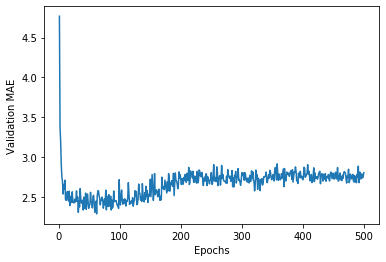

In [35]:
# 코드 3-30 검증 점수 그래프
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

fig5 = plt.gcf()

plt.draw()
fig5.savefig('fig5.png', dpi=100)

* 스케일이 다른 첫 10개의 데이터를 제외


* 부드러운 곡선을 위해 지수 이동 평균(exponential moving average) 으로 대체


* 지수이동평균 : 시계열 데이터를 부드럽게 만드는 기법으로, 이전에 계산된 이동 평균에 factor를 곱하고 현재 포인트에 (1-factor)만큼을 곱해 합산하는 방법, 최신 정보에 가중치를 둠으로써 학습률이 둔화되는 속도를 늦추는 방법

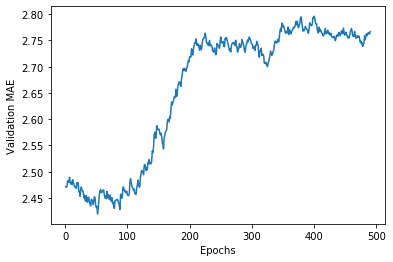

In [36]:
# 코드 3-31 처음 10개의 데이터 포인트를 제외한 검증 점수 그리기
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [37]:
# 코드 3-32 최종 모델 훈련하기
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print(test_mae_score)

102/102 [==============================] - 0s 2ms/step
2.627149927849863
